# Custom map simulations

In this tutorial we will build a simulation from scratch.

We start by defining a `Band` that will determine our array's sensitivity to different spectra. We then generate an array by specifying a field of view, which will be populated by evenly-spaced beams of the given band.

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)


We next define an array config, which specifies how detectors will be distributed on the focal plane. In this case, we supply our two bands as the `bands` argument, which will generate an array of multichroic detectors (for monochroic detectors, we would supply e.g. `"bands": [f090]`). The resolution of each detector is determined by frequency of the band and the `primary_size` parameter. The number of detectors is determined by filling up the specified `field_of_view` with detector beams, with a relative spacing determined by the `beam_spacing` parameter.

Instrument(1 array)
├ arrays:
│             n     FOV baseline        bands polarized
│  array1  1798  29.74’      0 m  [f090,f150]     False
│ 
└ bands:
      name   center   width    η         NEP   NET_RJ     NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s  0.5832’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s      21”


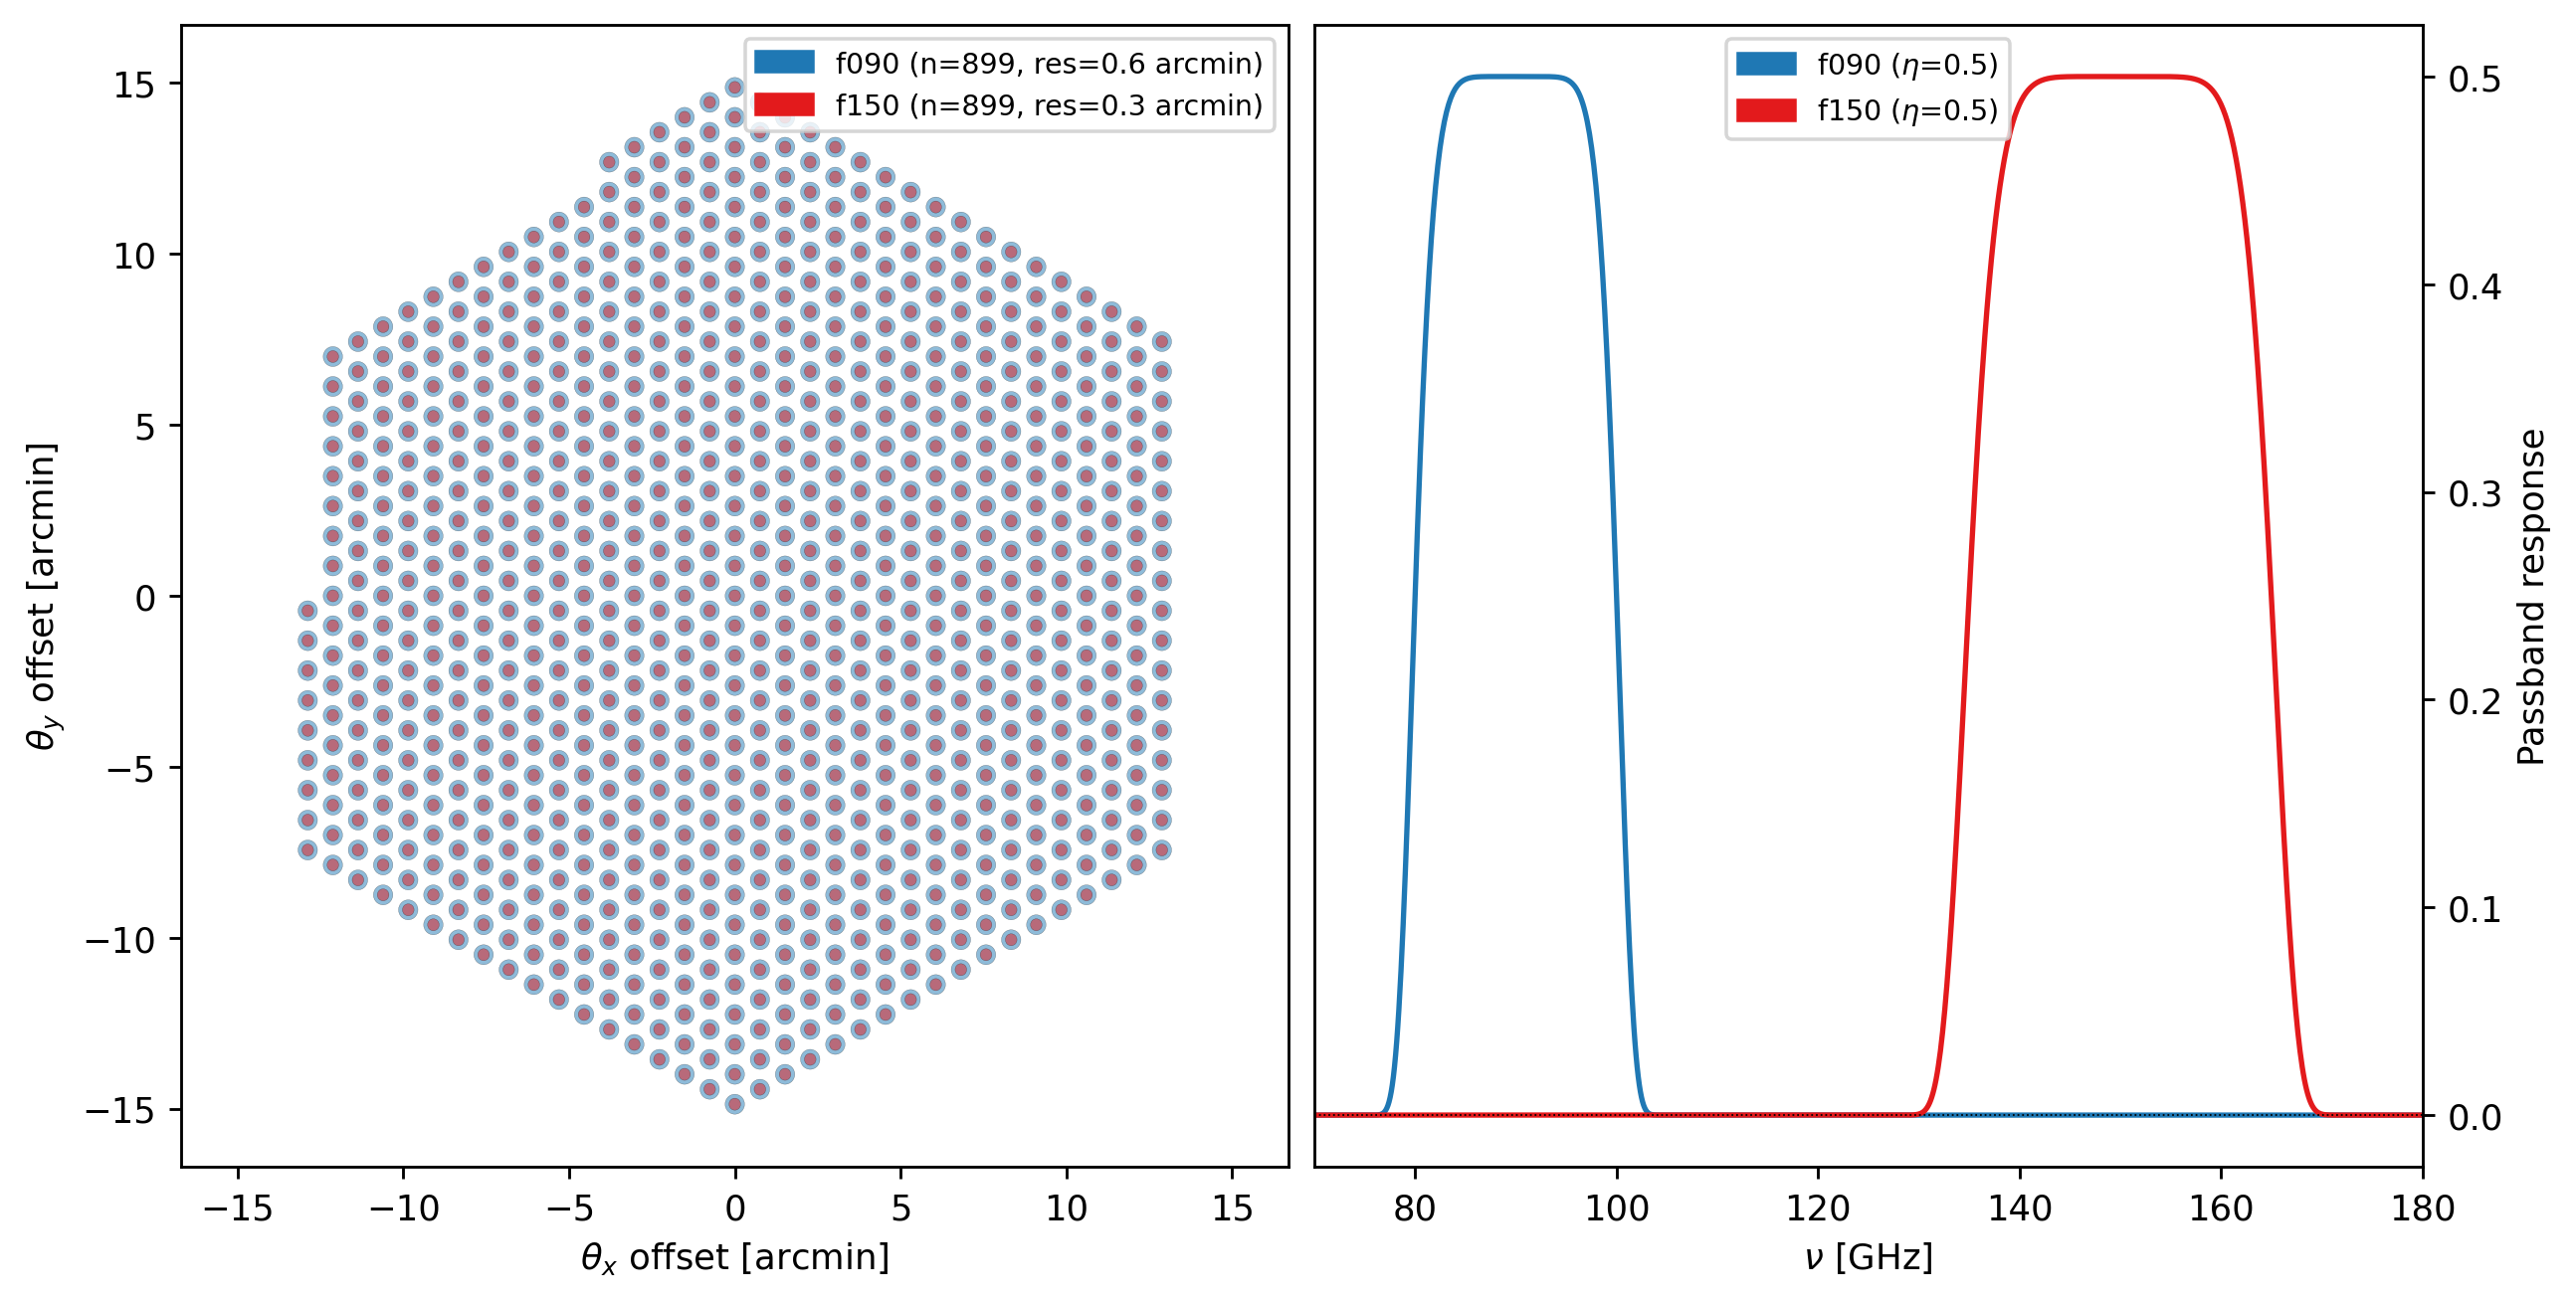

In [2]:
array = {"field_of_view": 0.5, 
         "beam_spacing": 1.5,
         "primary_size": 25, 
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument)
instrument.plot()

The `Site` defines the observing location, as well as the weather conditions. ``maria`` knows about a bunch of astronomical observing sites (to see them, run `print(maria.site_data)`); we can instantiate them using the `get_site` function. We can modify the site by passing kwargs to the ``get_site`` function, like changing its `altitude` (which will affect the vertical profile of different atmospheric parameters). 

Site:
  region: chajnantor
  location:
    lat: 23°01’45.84” S
    lon: 67°45’17.28” W
    alt: 5065 m
  seasonal: True
  diurnal: True


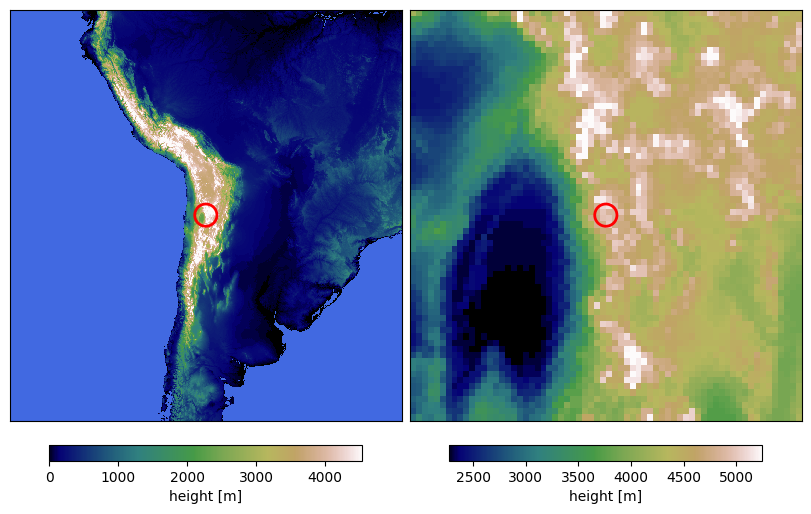

In [3]:
site = maria.get_site("llano_de_chajnantor", altitude=5065)

print(site)
site.plot()

Here the `fetch` function downloads a map to the path `map_filename`, but `map_filename` can be any `.h5` or `.fits` file of an image that corresponds to the `maria` map convention (see [Maps](https://thomaswmorris.com/maria/usage/inputs/maps)). Additional kwargs added to the `maria.map.load` overwrite the metadata of the loaded map.

ProjectedMap:
  shape(nu, y, x): (1, 1024, 1024)
  stokes: naive
  nu: [150.] GHz
  t: naive
  z: naive
  quantity: spectral_flux_density_per_pixel
  units: Jy/pixel
    min: -1.923e-04
    max: -2.502e-07
  center:
    ra:  19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
  size(y, x): (1°, 1°)
  resolution(y, x): (3.516”, 3.516”)
  beam(maj, min, rot): (0°, 0°, 0°)
  memory: 16.78 MB


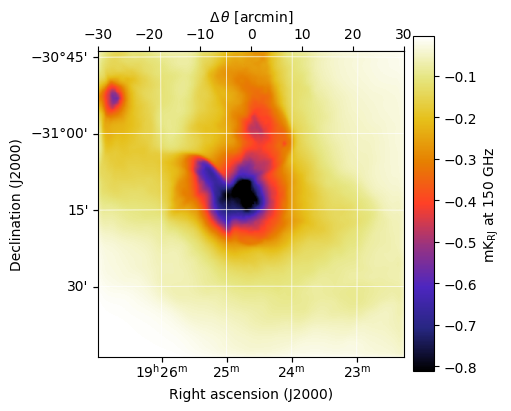

In [4]:
from maria.io import fetch

map_filename = fetch("maps/cluster1.fits")

input_map = maria.map.load(
    filename=map_filename,
    nu=150e9,
    center=(291.156, -31.23))
input_map.data *= 5e1 

print(input_map)
input_map.to("K_RJ").plot()

We plan an observation using the `Planner`, which ensures that a given `target` as seen by a given `site` will be high enough above the horizon.

Plan:
  duration: 1200 s
    start: 2024-08-06 03:00:00.000 +00:00
    end:   2024-08-06 03:20:00.000 +00:00
  location: 
    lat: 23°01’45.84” S
    lon: 67°45’17.28” W
    alt: 5065 m
  sample_rate: 50 Hz
  center:
    ra:  19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
    az(mean): 198.9°
    el(mean): 81.24°
  scan_pattern: daisy
  scan_radius: 0.666°
  scan_kwargs: {'radius': np.float64(0.3333333333333333)}


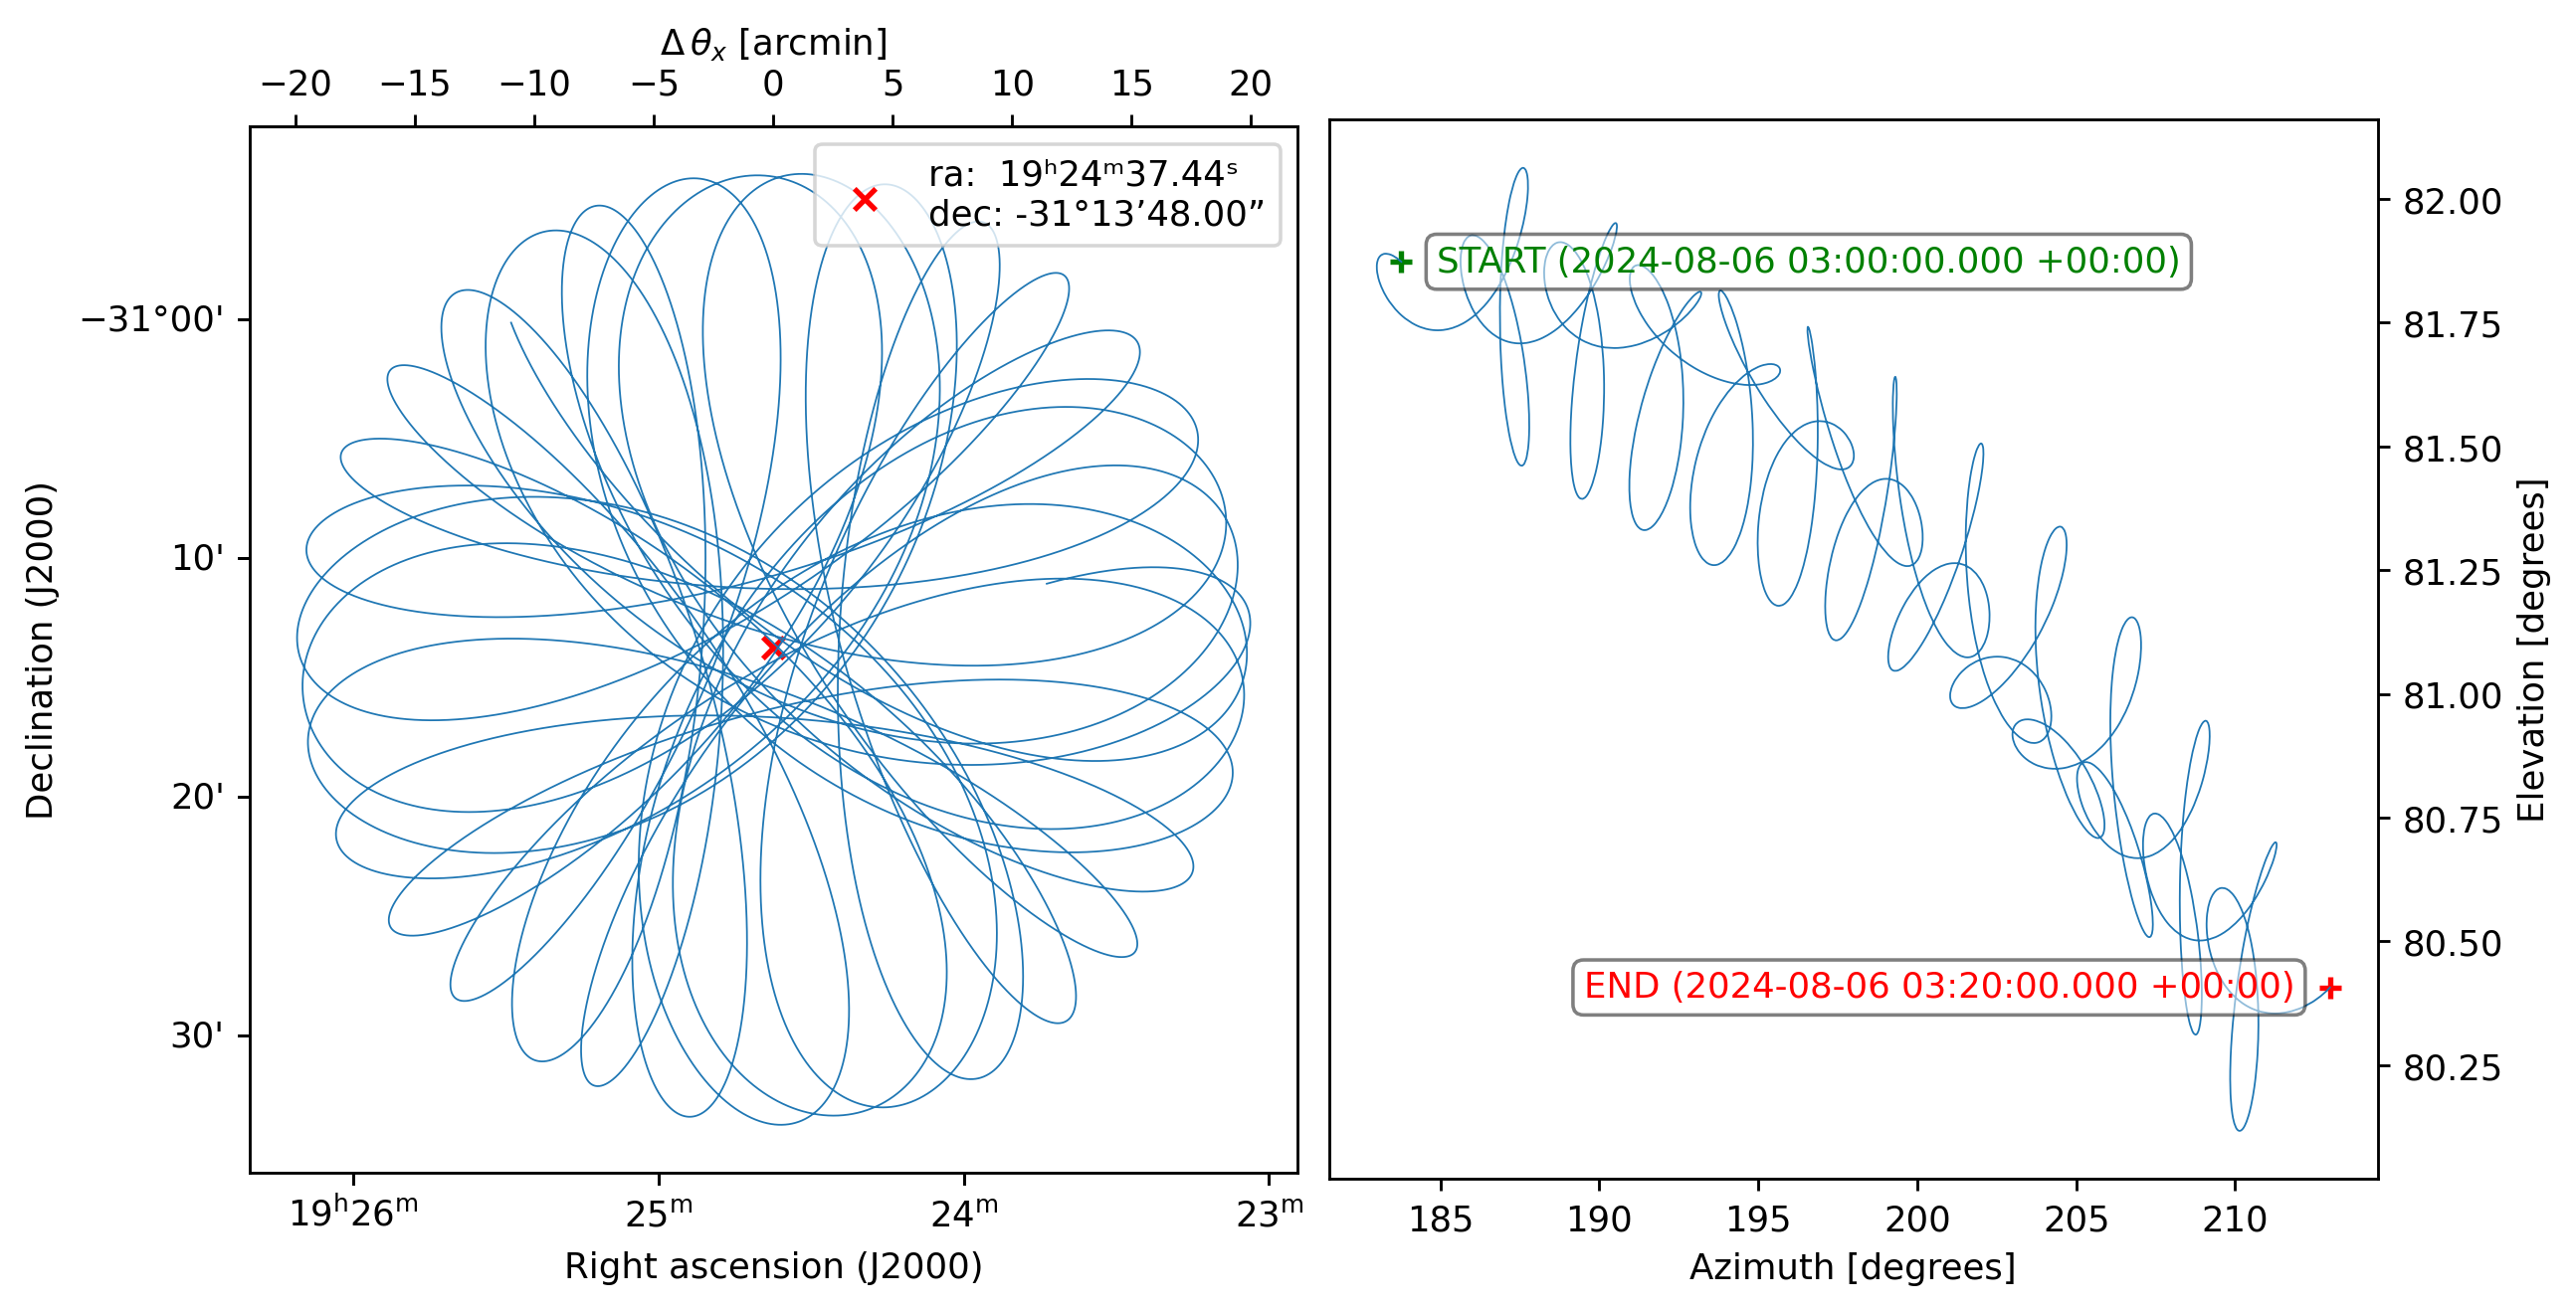

In [5]:
from maria import Planner

planner = Planner(start_time="2024-08-06T03:00:00",
                  target=input_map, 
                  site=site, 
                  el_bounds=(40, 90))

plan = planner.generate_plan(total_duration=1200,  # in seconds
                             scan_pattern="daisy",
                             scan_options={"radius": input_map.width.deg / 3},
                             sample_rate=50)

print(plan)
plan.plot()

Text(0.1, 0.1, 'abc')

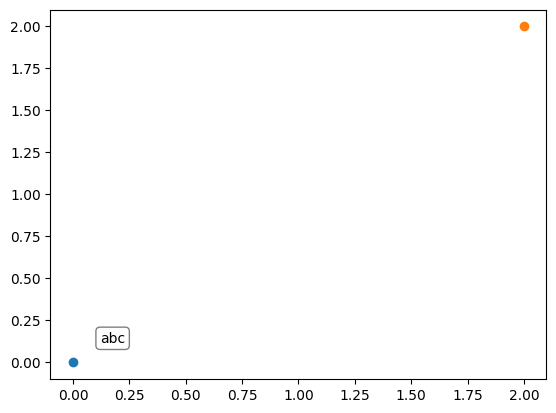

In [6]:
import matplotlib.pyplot as plt

plt.scatter(0,0)
plt.scatter(2,2)

plt.annotate(xy=(0, 0), xycoords='data', xytext=(0.1, 0.1), textcoords="axes fraction", text="abc", bbox={"boxstyle": "round,pad=0.3", "fc": "w", "ec": "k", "alpha": 0.5, "lw": 1}, )

In [7]:
sim = maria.Simulation(
    instrument,
    plan=plan,
    site=site,
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map)

print(sim)

Constructing atmosphere:   0%|          | 0/10 [00:00<?, ?it/s]

Constructing atmosphere:  10%|█         | 1/10 [00:04<00:38,  4.30s/it]

Constructing atmosphere:  20%|██        | 2/10 [00:08<00:33,  4.20s/it]

Constructing atmosphere:  30%|███       | 3/10 [00:13<00:30,  4.37s/it]

Constructing atmosphere:  40%|████      | 4/10 [00:17<00:27,  4.52s/it]

Constructing atmosphere:  50%|█████     | 5/10 [00:22<00:22,  4.56s/it]

Constructing atmosphere:  60%|██████    | 6/10 [00:27<00:18,  4.60s/it]

Constructing atmosphere:  70%|███████   | 7/10 [00:31<00:14,  4.70s/it]

Constructing atmosphere:  80%|████████  | 8/10 [00:36<00:09,  4.68s/it]

Constructing atmosphere:  90%|█████████ | 9/10 [00:41<00:04,  4.75s/it]

Constructing atmosphere: 100%|██████████| 10/10 [00:46<00:00,  4.81s/it]

Constructing atmosphere: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │             n     FOV baseline        bands polarized
│ │  array1  1798  29.74’      0 m  [f090,f150]     False
│ │ 
│ └ bands:
│       name   center   width    η         NEP   NET_RJ     NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s  0.5832’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s      21”
├ Site:
│   region: chajnantor
│   location:
│     lat: 23°01’45.84” S
│     lon: 67°45’17.28” W
│     alt: 5065 m
│   seasonal: True
│   diurnal: True
├ Plan:
│   duration: 1200 s
│     start: 2024-08-06 03:00:00.000 +00:00
│     end:   2024-08-06 03:20:00.000 +00:00
│   location: 
│     lat: 23°01’45.84” S
│     lon: 67°45’17.28” W
│     alt: 5065 m
│   sample_rate: 50 Hz
│   center:
│     ra:  19ʰ24ᵐ37.44ˢ
│     dec: -31°13’48.00”
│     az(mean): 198.9°
│     el(mean): 81.24°
│   scan_pattern: daisy
│   scan_radius: 0.666°
│   scan_kwargs: {'radius': np.float64(0.3333333333333333)}


We run the simulation, which spits out a `TOD` object (which stands for time-ordered data). We can then plot the `TOD`:

Generating turbulence:   0%|          | 0/10 [00:00<?, ?it/s]

Generating turbulence:  30%|███       | 3/10 [00:00<00:00, 17.75it/s]

Generating turbulence:  50%|█████     | 5/10 [00:00<00:00, 13.99it/s]

Generating turbulence:  70%|███████   | 7/10 [00:00<00:00, 11.48it/s]

Generating turbulence:  90%|█████████ | 9/10 [00:00<00:00,  9.66it/s]

Generating turbulence: 100%|██████████| 10/10 [00:00<00:00, 10.25it/s]

Sampling turbulence:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling turbulence:  10%|█         | 1/10 [00:02<00:21,  2.36s/it]

Sampling turbulence:  20%|██        | 2/10 [00:04<00:18,  2.27s/it]

Sampling turbulence:  30%|███       | 3/10 [00:06<00:15,  2.28s/it]

Sampling turbulence:  40%|████      | 4/10 [00:09<00:13,  2.31s/it]

Sampling turbulence:  50%|█████     | 5/10 [00:11<00:11,  2.31s/it]

Sampling turbulence:  60%|██████    | 6/10 [00:13<00:09,  2.31s/it]

Sampling turbulence:  70%|███████   | 7/10 [00:16<00:06,  2.33s/it]

Sampling turbulence:  80%|████████  | 8/10 [00:18<00:04,  2.34s/it]

Sampling turbulence:  90%|█████████ | 9/10 [00:20<00:02,  2.36s/it]

Sampling turbulence: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]

Sampling turbulence: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:08<00:08,  8.79s/it, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:08<00:08,  8.79s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:17<00:00,  8.66s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:17<00:00,  8.68s/it, band=f150]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Sampling map:   0%|          | 0/2 [00:06<?, ?it/s, channel=(0 Hz, inf Hz)]

Sampling map:  50%|█████     | 1/2 [00:16<00:16, 16.87s/it, channel=(0 Hz, inf Hz)]

Sampling map:  50%|█████     | 1/2 [00:16<00:16, 16.87s/it, band=f150]             

Sampling map:  50%|█████     | 1/2 [00:24<00:16, 16.87s/it, channel=(0 Hz, inf Hz)]

Sampling map: 100%|██████████| 2/2 [00:33<00:00, 16.79s/it, channel=(0 Hz, inf Hz)]

Sampling map: 100%|██████████| 2/2 [00:33<00:00, 16.81s/it, channel=(0 Hz, inf Hz)]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|█████     | 1/2 [00:01<00:01,  1.88s/it, band=f090]

Generating noise:  50%|█████     | 1/2 [00:01<00:01,  1.88s/it, band=f150]

Generating noise: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it, band=f150]

Generating noise: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it, band=f150]

TOD(shape=(1798, 60000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2024-08-06 03:19:59.978 +00:00, duration=1200.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-07-12T17:54:43.094920+00:00]>, 'altitude': 5065.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 272.519})


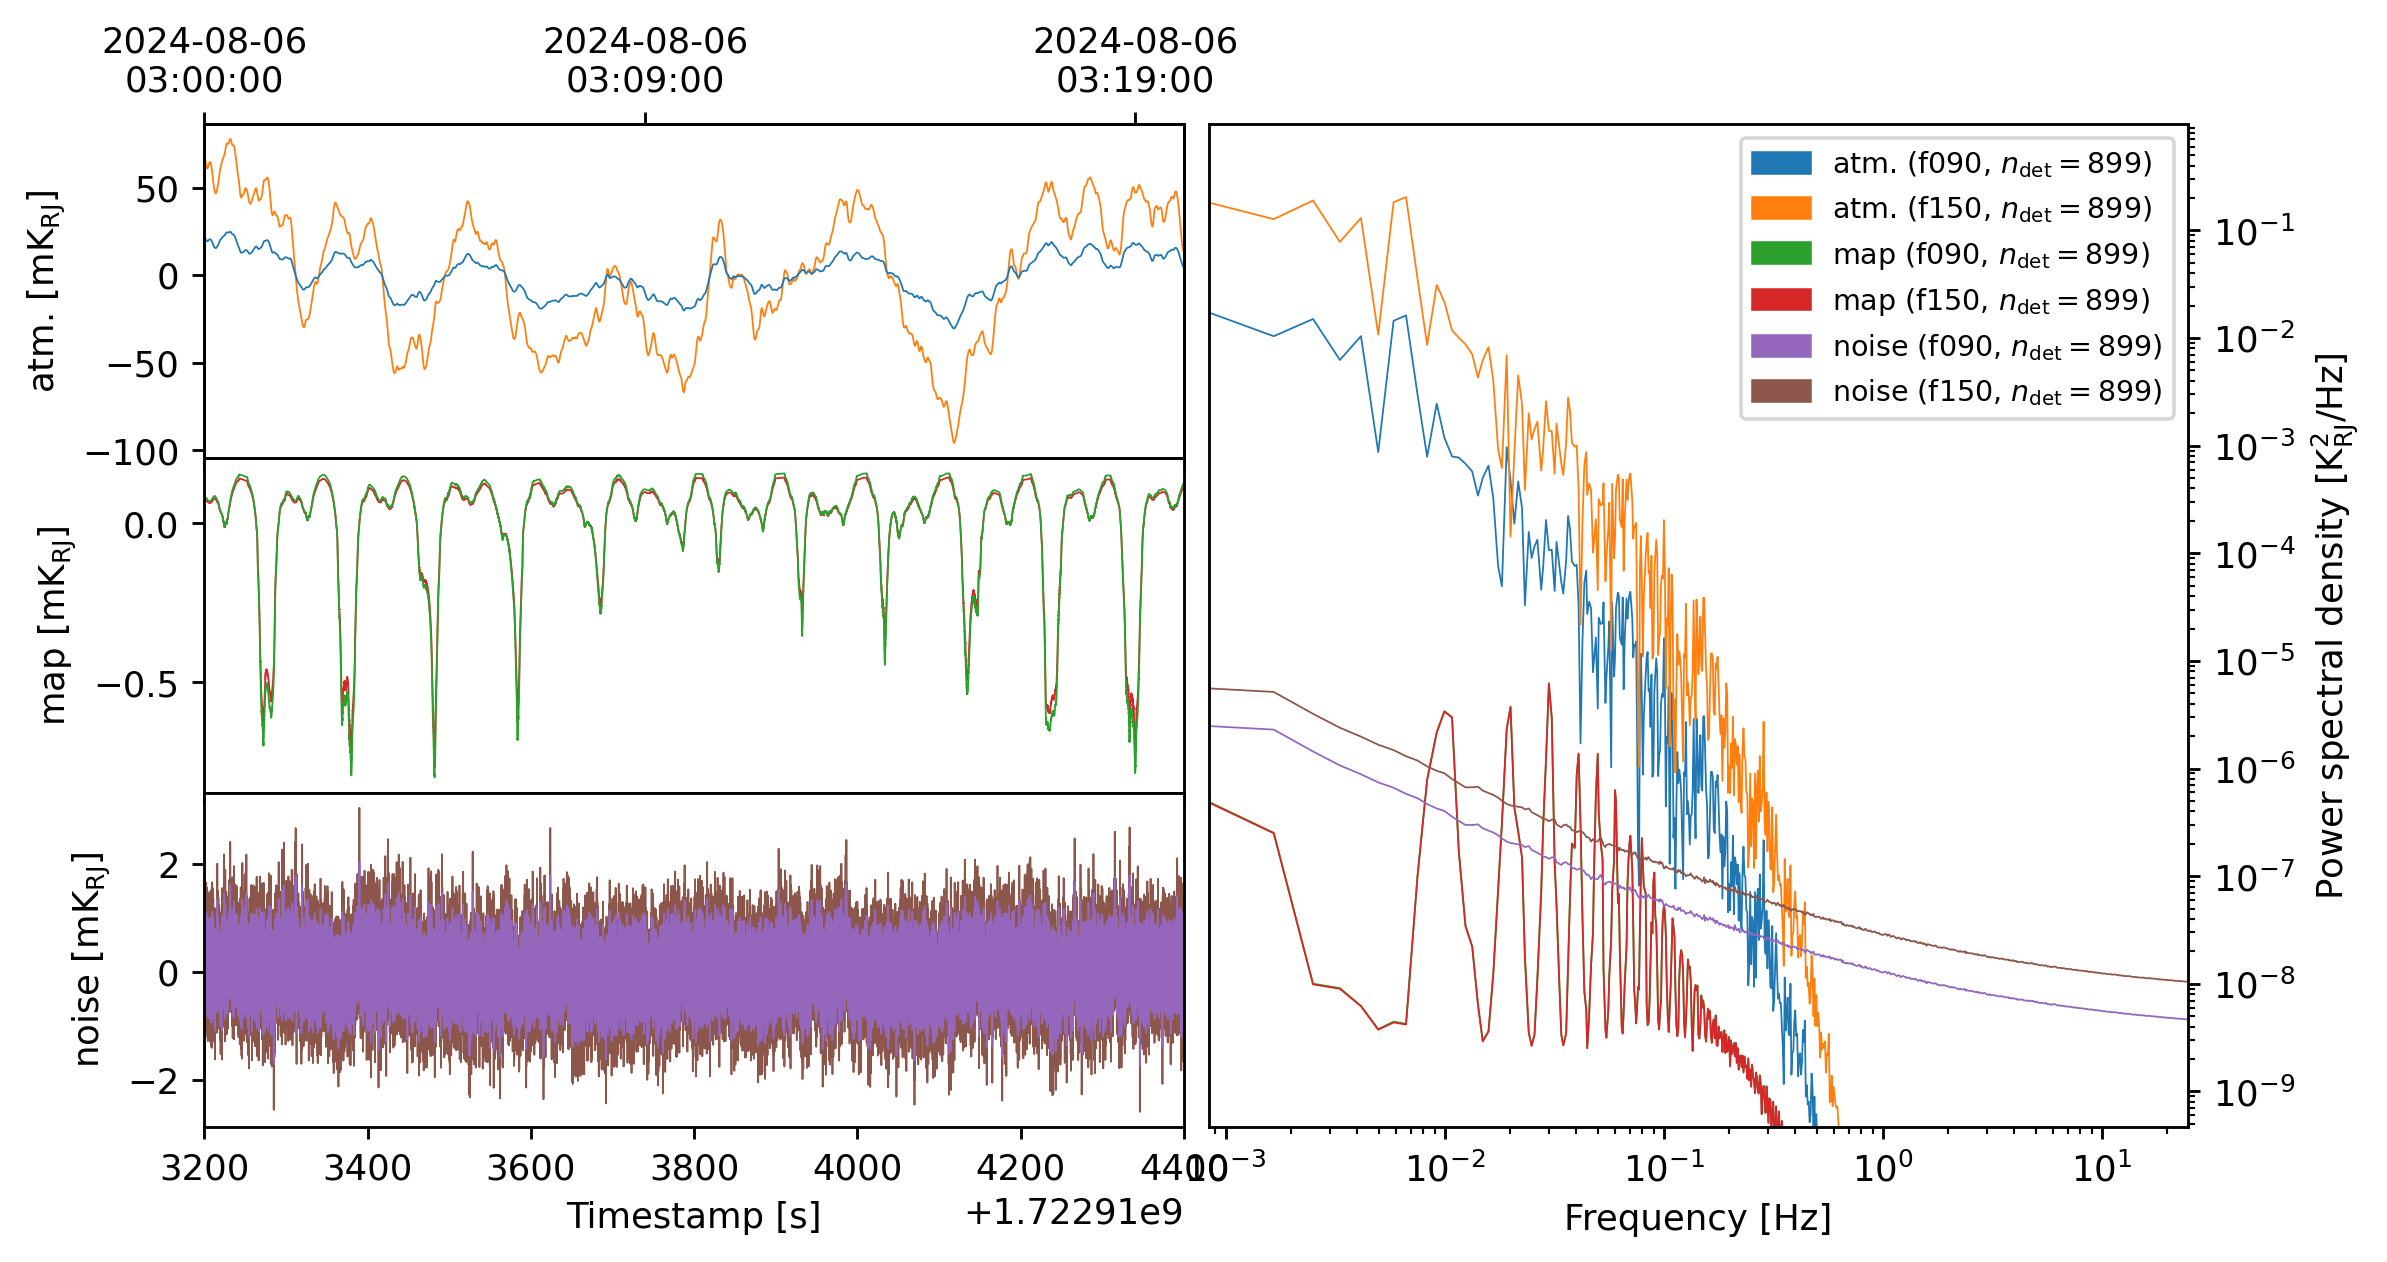

In [8]:
tod = sim.run()

print(tod)
tod.plot()

We can then map the `TOD` using the built-in mapper.

In [9]:
from maria.mappers import BinMapper

mapper = BinMapper(
    center=input_map.center,
    frame="ra_dec",
    width=input_map.width,
    height=input_map.height,
    resolution=input_map.width / 256,
    tod_preprocessing={
        "window": {"name": "tukey", "kwargs": {"alpha": 0.1}},
        "remove_spline": {"knot_spacing": 30, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": [0]},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
    },
    units="mK_RJ",
)

mapper.add_tods(tod)

output_map = mapper.run()

Mapping band f090:   0%|          | 0/1 [00:00<?, ?it/s]

Mapping band f090:   0%|          | 0/1 [00:00<?, ?it/s, band=f090, stokes=I]

Mapping band f090: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, band=f090, stokes=I]

Mapping band f090: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, band=f090, stokes=I]


2025-07-12 17:56:05.475 INFO: Ran mapper for band f090 in 13.8 s.


Mapping band f150:   0%|          | 0/1 [00:00<?, ?it/s]

Mapping band f150:   0%|          | 0/1 [00:00<?, ?it/s, band=f150, stokes=I]

Mapping band f150: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, band=f150, stokes=I]

Mapping band f150: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, band=f150, stokes=I]


2025-07-12 17:56:18.748 INFO: Ran mapper for band f150 in 13.27 s.


We can see the recovered map with

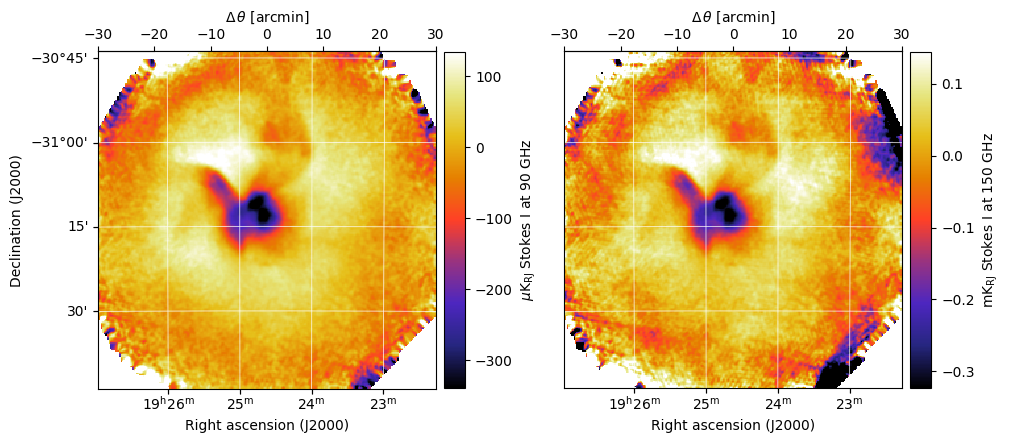

In [10]:
output_map.plot(nu_index=[0, 1])